### In this notebook the reasoning behind the use of exponential modelling of temporal decorrelation (Equation 6) in InSAR4SM pipeline is presented.



[Morishita and Hanssen, 2015](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6862005) introduced the following relationship to model the temporal decorrelationship due to the motion of scatterers. According to this study, the motion of the scatterers can be divided into a **near-instantaneous short term** and a  **time-dependent long-term component** (vegetation growth).

$ \gamma_{dry} = (\gamma_0 - \gamma_p)e^{t/\tau} + \gamma_p$

INSAR4SM works when <u>short-term vegetation effects</u> (e.g. due to anthropogenic activities) are negligible. This is considered a valid assumption over regions that are not cultivated or have low vegetation cover.  
However, we still have to mitigate <u>long-term temporal decorrelation</u>  (vegetation growth). In the figure below we can observe the temporal patterns of normalized difference vegetation index (NDVI) over the AOI.  In the bottom right corner, we can also observe a cropland region with frequent ndvi variations.


<img src="figures/ndvi_colorbar.png" width="50" align="center">
<img src="figures/S2L2A-ndvi-timelapse.gif" width="500" align="center">

The normalized difference vegetation index (NDVI) is a simple, but effective index for quantifying green vegetation. More info [here](https://custom-scripts.sentinel-hub.com/sentinel-2/ndvi/)


According to INSAR4SM pipeline, we model the long-term temporal decorrelation **only** over images that experience <u>low surface soil moisture </u> (SSM).
InSAR4SM exploits only low SSM acquisitions because coherence changes due to soil moisture variations are going to be used for SSM estimation.
This way we model the long-term temporal decorrelation over time and we are able to estimate coherence due to soil moisture more accurately.

In [104]:
import os, pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from collections import Counter
import pandas as pd

In [105]:
def temp_coh__model(t:np.array, gamma_0:float, tau:float, gamma_k:float)->np.array:
    """Exponential model between time and coherence due to temporal decorrelation according to Parizzi et al., 2009

    .. math:: \gamma_t = (\gamma_0 - \gamma_k)e^{-t/\tau} + \gamma_k

    Args:
        t (np.array): known quantity (time spans) 
        gamma_0 (float): parameter to estimated
        tau (float): parameter to estimated
        gamma_k (float): parameter to estimated

    Returns:
        np.array: modelled data (coherence due to temporal decorrelation)

    ..References:
        Parizzi, A., Cong, X., & Eineder, M. (2009). First Results from Multifrequency Interferometry. A comparison of different decorrelation time constants at L, C, and X Band. ESA Scientific Publications, (SP-677), 1-5.
    """
 
    gamma_t = (gamma_0-gamma_k)* np.exp(-t/tau) + gamma_k
    
    return gamma_t  

In [106]:
def calc_coh_decor_model(InSAR4SM_point_obj, max_flag = False):

    # Load data
    Datetimes = InSAR4SM_point_obj.slc_dates
    SM_sorting = InSAR4SM_point_obj.best_sorting
    n_bands = InSAR4SM_point_obj.nbands
    n_ds = InSAR4SM_point_obj.n_ds
    ind_DS = InSAR4SM_point_obj.DS_ind
    coh_full_DS = InSAR4SM_point_obj.coh_full_DS
    band_start = InSAR4SM_point_obj.start_index
    band_end = InSAR4SM_point_obj.end_index
    n_dry_bands = InSAR4SM_point_obj.n_dry_bands

    Datetimes = Datetimes[band_start:band_end].copy()
    coh = coh_full_DS[ind_DS,band_start:band_end,band_start:band_end].copy()
    coh[np.diag_indices_from(coh)] = np.nan
    dry_bands_inds = SM_sorting[:n_dry_bands].copy()
    #%% 2. In order to be sure about the selected dry bands we construct the 
    # cohence matrix of dry bands x dry bands. We expect to see high 
    # values because of the small sm variations between dry values

    #coh = (coh - np.nanmin(coh)) / (np.nanmax(coh) - np.nanmin(coh))

    # Selection of coherence values related with dry acquisitions
    coh_dry = coh[dry_bands_inds,:][:, dry_bands_inds].copy()

    # identify "not-dry" bands and update the indices of dry bands
    bad_dry_bands = (coh_dry<np.nanquantile(coh_dry.flatten(), 0.1)).nonzero()[0]
    drop_dry_bands = [item for item, count in Counter(bad_dry_bands).items() if count > 1]
    drop_dry_bands_inds = SM_sorting[drop_dry_bands]
    drop_dry_bands_indices=np.argwhere(np.isin(dry_bands_inds , drop_dry_bands_inds))
    dry_bands_inds=np.delete(dry_bands_inds,drop_dry_bands_indices)

    # update the number of dry bands
    n_dry_bands = dry_bands_inds.shape[0]

    # update the dry coherence matrix
    coh_dry = coh[dry_bands_inds,:][:, dry_bands_inds].copy()

    # select only the upper triangular elements
    num_tri_elements = np.triu_indices_from(coh_dry,1)[0].shape[0]
    num_tri_indices = np.triu_indices_from(coh_dry,1)
    indices1 = num_tri_indices[0]
    indices2 = num_tri_indices[1]

    # Get the temporal infrormation of dry bands
    dry_datetimes = Datetimes[dry_bands_inds]

    #%% 3. calculate coherence related to long term temporal decorrelation
    # initialization

    # get the coherence values for each time combination of dry dates
    Dt = np.array([np.abs((dry_datetimes[indices2[int_n]]-dry_datetimes[indices1[int_n]]).days) for int_n in range(num_tri_elements)])
    Permanent_Cohs = np.asarray(coh_dry[num_tri_indices])

    # select the maximum coherence values for each time combination
    coh_time_df = pd.DataFrame(np.array([Dt,Permanent_Cohs])).T
    max_coh_time_df = coh_time_df.groupby([0]).max()
    Dt_max = max_coh_time_df.index.values
    Permanent_max_Cohs = max_coh_time_df[1].values

    if max_flag:
        fit = curve_fit(temp_coh__model, Dt_max, Permanent_max_Cohs, maxfev = 2000)
        gamma_0, tau, gamma_k = fit[0]
        gamma_t_modelled = temp_coh__model(Dt, gamma_0, tau, gamma_k)
    else:
        fit = curve_fit(temp_coh__model, Dt, Permanent_Cohs, maxfev = 2000)
        gamma_0, tau, gamma_k = fit[0]
        gamma_t_modelled = temp_coh__model(Dt, gamma_0, tau, gamma_k)
    return gamma_0, tau, gamma_k, gamma_t_modelled , Permanent_max_Cohs, coh_time_df

Text(0, 0.5, 'Coherence')

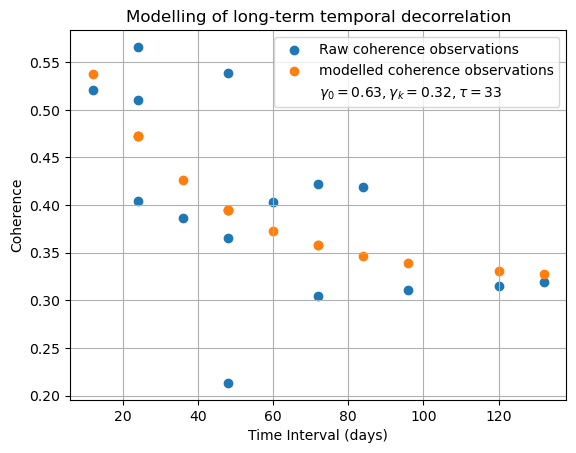

In [110]:
with open('Data/INSAR4SM_r1_orb166_125m_FordDryLake_sm_point_ts.obj', 'rb') as inp:
    FordDryLake_166 = pickle.load(inp)
gamma_0, tau, gamma_k, gamma_t_modelled , Permanent_max_Cohs, coh_time_df = calc_coh_decor_model(FordDryLake_166)
plt.title('Modelling of long-term temporal decorrelation')
plt.scatter(x = coh_time_df[0], y = coh_time_df[1], label='Raw coherence observations')
plt.scatter(x = coh_time_df[0], y = gamma_t_modelled, label='modelled coherence observations')
plt.plot([], [], ' ', label=r"$ \gamma_0 = {:.2f}, \gamma_k = {:.2f}, \tau = {:.0f}$".format(gamma_0, gamma_k,tau))
plt.legend()
plt.grid(True)
plt.xlabel('Time Interval (days)')
plt.ylabel('Coherence')